In [20]:
from utils import *

import math
import numpy as np
import scipy.io as sio
from scipy.special import digamma
from scipy.stats import multinomial, dirichlet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import scipy.io as sio


rseed = 3
np.random.seed(rseed)

Multinomial

In [ ]:

from scipy.stats import multinomial
import scipy.io as sio
import numpy as np
import math


def Multinomial(A, B, alpha=0):
    """Fit multinomial over words with optional Dirichlet smoothing. Returns (pi, results dict)."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])

    # ML estimate with Dirichlet pseudocounts
    pi = np.array([np.sum(A[:, 2][A[:, 1] == w]) for w in range(1, W + 1)])
    pi = pi + alpha
    cc = np.copy(pi)
    pi = pi / np.sum(pi)

    unique_docs = np.unique(B[:, 0])
    res = {'cc': cc}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = multinomial.logpmf(ow, n=nd, p=pi)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return pi, res


def Categorical(A, B, pi):
    """Log-prob under categorical (avoids multinomial coefficient). Handles zero-prob words."""
    logpi = np.log(pi)

    def logpmf(ow, n, lp, pi):
        assert sum(ow) == n
        mask = pi <= 0.0
        if np.sum(ow[mask]) > 0:
            return -np.inf
        return np.sum(np.where(mask, 0, ow * lp))

    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    unique_docs = np.unique(B[:, 0])
    res = {}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = logpmf(ow, n=nd, lp=logpi, pi=pi)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return res


def LogBetaFunction(c):
    """Log of multivariate Beta function: log B(c) = sum log Gamma(c_i) - log Gamma(sum c_i)."""
    return sum(math.lgamma(q) for q in c) - math.lgamma(sum(c))


def LogDocumentProbability(c, c0):
    """Log predictive probability of doc counts c under Dirichlet posterior with pseudocounts c0."""
    return LogBetaFunction(c + c0) - LogBetaFunction(c0)


def DistributionExpectation(A, B, c0):
    """Per-document log-prob and perplexity using Dirichlet-multinomial (integrating out pi)."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    unique_docs = np.unique(B[:, 0])
    res = {}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = LogDocumentProbability(ow, c0)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return res


BMM

In [ ]:
import scipy.io as sio
import numpy as np


def BMM(A, B, K, alpha, gamma):
    """Gibbs sampler for mixture of multinomials with Dirichlet priors."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    D = np.max(A[:, 0])

    # random init: assign docs to components
    sd = np.floor(K * np.random.rand(D)).astype(int)
    swk = np.zeros((W, K))       # word counts per component
    sk_docs = np.zeros((K, 1), dtype=int)  # doc counts per component

    for d in range(D):
        idx = np.where(A[:, 0] == d + 1)
        w, c = np.array(A[idx, 1]), np.array(A[idx, 2])
        k = sd[d]
        swk[w-1, k] += c
        sk_docs[k] += 1

    sk_docs_tracker = [np.copy(sk_docs)]
    sk_words = np.sum(swk, axis=0)

    num_iters_gibbs = 50
    for iter in range(num_iters_gibbs):
        for d in range(D):
            idx = np.where(A[:, 0] == d + 1)
            w, c = A[idx, 1], A[idx, 2]
            old_class = sd[d]

            # remove doc d from counts
            swk[w-1, old_class] -= c
            sk_docs[old_class] -= 1
            sk_words[old_class] -= np.sum(c)

            # conditional log-prob for each component
            lb = np.zeros(K)
            for k in range(K):
                ll = np.dot(np.log(swk[w-1, k] + gamma) - np.log(sk_words[k] + gamma * W), c.T)
                lb[k] = np.log(sk_docs[k] + alpha) + ll

            b = np.exp(lb - np.max(lb))
            kk = sampleDiscrete(b, np.random.rand())

            # add doc d back under new assignment
            swk[w-1, kk] += c
            sk_docs[kk] += 1
            sk_words[kk] += np.sum(c)
            sd[d] = kk

        sk_docs_tracker.append(np.copy(sk_docs))

    # test perplexity (log-sum-exp over components)
    lp, nd = 0, 0
    for doc in np.unique(B[:, 0]):
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1], B[idx, 2]
        z = np.log(sk_docs + alpha) - np.log(np.sum(sk_docs + alpha))
        for k in range(K):
            b = (swk[:, k] + gamma) / (sk_words[k] + gamma * W)
            z[k] += np.dot(c, np.log(b[w-1]).T)[0]
        lp += np.log(np.sum(np.exp(z - np.max(z)))) + np.max(z)
        nd += np.sum(c)

    perplexity = np.exp(-lp / nd)
    return perplexity, swk, sk_docs_tracker

LDA

In [ ]:
import scipy.io as sio
import numpy as np
from scipy.sparse import coo_matrix as sparse


def LDA(A, B, K, alpha, gamma):
    """Collapsed Gibbs sampler for LDA. Returns perplexity, word-topic counts, trackers."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    D = np.max(A[:, 0])

    # sparse word-doc count matrices
    swd = sparse((A[:, 2], (A[:, 1]-1, A[:, 0]-1))).tocsr()
    Swd = sparse((B[:, 2], (B[:, 1]-1, B[:, 0]-1))).tocsr()

    skd = np.zeros((K, D))
    swk = np.zeros((W, K))

    # random init of topic assignments
    s = []
    r = 0
    for d in range(D):
        z = np.zeros((W, K))
        words_in_doc_d = A[np.where(A[:, 0] == d+1), 1][0]-1
        for w in words_in_doc_d:
            c = swd[w, d]
            for i in range(c):
                k = np.floor(K*np.random.rand())
                z[w, int(k)] += 1
                r += 1
        skd[:, d] = np.sum(z, axis=0)
        swk += z
        s.append(sparse(z))

    sk = np.sum(skd, axis=1)
    skd_tracker = [np.copy(skd)]
    swk_tracker = [np.copy(swk)]

    #training sweeps
    num_gibbs_iters = 50
    for iter in range(num_gibbs_iters):
        print(f"Train sweep {iter+1}/{num_gibbs_iters}", end="\r")
        for d in range(D):
            z = s[d].todense()
            words_in_doc_d = A[np.where(A[:, 0] == d + 1), 1][0] - 1
            for w in words_in_doc_d:
                a = z[w, :].copy()
                indices = np.where(a > 0)[1]
                np.random.shuffle(indices)
                for k in indices:
                    k = int(k)
                    for i in range(int(a[0, k])):
                        # remove, resample, add back
                        z[w, k] -= 1
                        swk[w, k] -= 1
                        sk[k] -= 1
                        skd[k, d] -= 1
                        b = (alpha + skd[:, d]) * (gamma + swk[w, :]) \
                            / (W * gamma + sk)
                        kk = sampleDiscrete(b, np.random.rand())
                        z[w, kk] += 1
                        swk[w, kk] += 1
                        sk[kk] += 1
                        skd[kk, d] += 1

            s[d] = sparse(z)
        skd_tracker.append(np.copy(skd))
        swk_tracker.append(np.copy(swk))
    print()

    # test perplexity (held-out docs, fixed phi)
    lp, nd = 0, 0
    unique_docs_in_b = np.unique(B[:, 0])
    for qq, d in enumerate(unique_docs_in_b, 1):
        print(f"Test doc {qq}/{len(unique_docs_in_b)}", end="\r")
        z = np.zeros((W, K))
        words_in_d = B[np.where(B[:, 0] == d), 1][0]-1
        for w in words_in_d:
            c = Swd[w, d-1]
            for i in range(c):
                k = np.floor(K * np.random.rand())
                z[w, int(k)] += 1

        Skd = np.sum(z, axis=0)
        # burn-in on test doc
        num_gibbs_iters = 50
        for iters in range(num_gibbs_iters):
            for w in words_in_d:
                a = z[w, :].copy()
                indices = np.where(a > 0)[0]
                np.random.shuffle(indices)
                for k in indices:
                    k = int(k)
                    for i in range(int(a[k])):
                        z[w, k] -= 1
                        Skd[k] -= 1
                        b = (alpha + Skd) * (gamma + swk[w, :]) / (W * gamma + sk)
                        kk = sampleDiscrete(b, np.random.rand())
                        z[w, kk] += 1
                        Skd[kk] += 1

        # p(w) = sum_k theta_k * phi_kw
        b1 = ((alpha + Skd) / np.sum(alpha + Skd))[:, None]
        b2 = (gamma + swk) / (W * gamma + sk)
        b = np.matmul(b2, b1)
        words_and_counts = B[np.where(B[:, 0] == d), 1:][0]
        lp += np.dot(np.log(b[words_and_counts[:, 0]-1]).T, words_and_counts[:, 1])
        nd += np.sum(words_and_counts[:, 1])

    perplexity = np.exp(-lp/nd)
    return perplexity, swk, skd_tracker, swk_tracker

Task

In [ ]:
A, B, V = load_ml("kos_doc_data.mat")

In [ ]:
K = 20
alpha, gamma = 0.1, 0.1
perplexity, swk, skd_tracker, swk_tracker = LDA(A, B, K, alpha, gamma)

1: Processing step 50


In [ ]:
print("LDA perplexity:", perplexity[0])

indices = np.argsort(-swk, axis=0)[:20, :]
top_words = V[indices]

# print top 5 words per topic
I = 5
for topw in top_words[:, :, 0]:
    print()
    for word in topw[:I]:
        print(word[0], end=(20 - len(word[0])) * " ")

Perplexity of LDA 1641.2361361933313

money               delay               senate              people              november            
house               house               senator             campaign            poll                
campaign            committee           republican          political           house               
senate              texas               carson              politics            polls               
million             republicans         bunning             party               republicans         
candidates          ethics              coburn              media               account             
democratic          leader              oklahoma            america             electoral           
party               democrats           debate              family              governor            
elections           republican          issues              message             senate              
democrats           majority            mongiardo    

In [ ]:
# topic proportions across sweeps
pis = np.zeros((len(swk_tracker), K))
for i in range(pis.shape[0]):
    theta_dk = alpha + skd_tracker[i]
    theta_dk = theta_dk / theta_dk.sum(axis=0, keepdims=True)
    pis[i] = theta_dk.mean(axis=1)

pis = pis / np.sum(pis, axis=1, keepdims=True)
tp = np.argmax(pis[-1])
print("Most likely topic:", tp)

Most likely topic 5


In [ ]:
for topic in top_words[:, tp, 0]:
    for word in topic:
        print(word, end = " ")

bush kerry poll percent voters polls general polling race results numbers lead states vote state election gallup zogby leads undecided 

```
    Saving the most likely topics here:
    
    seed 1: 1640.963, 13
            november poll house governor account electoral senate republicans polls turnout contact 
            qaqaa ground blast exit trouble materiel chemical duderino parecommend 
            
    seed 2: 1660.243, 18
            november electoral account house poll governor polls senate republicans vote kerry bush 
            sunzoo voter contact media store general labor voting  
            
    seed 3: 1643.618, 5
            bush kerry poll percent voters polls general polling race results numbers lead states vote 
            state election gallup zogby leads undecided
            
            
```

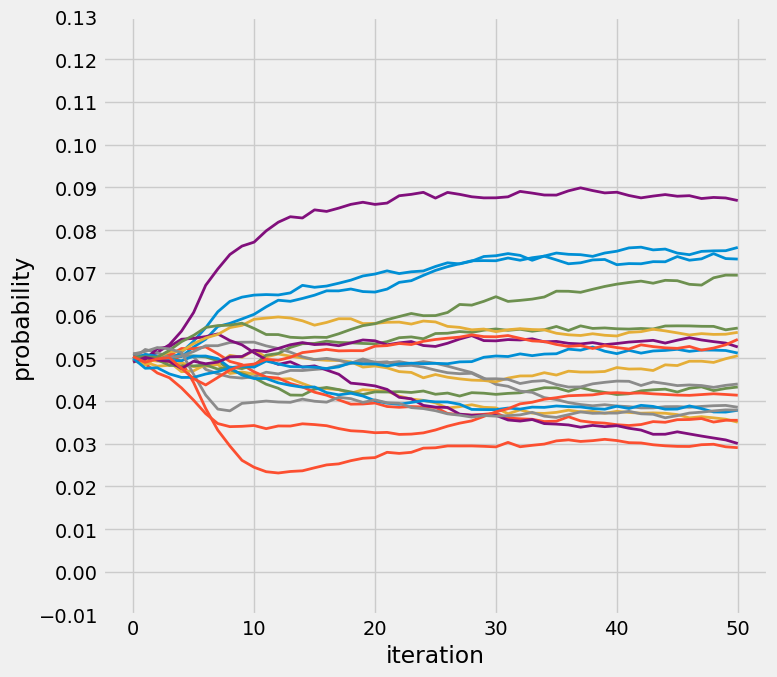

In [ ]:
# plot the probabilities with word idx and see how it compares to zipf's law
plt.figure(figsize = (8, 7))
plt.plot(pis, linewidth=2.0)
plt.ylabel('probability')
plt.xlabel('iteration')
plt.ylim(-0.01, 0.13)
plt.yticks(np.linspace(-0.01, 0.13, 15))

plt.tight_layout()
plt.show()

In [30]:
def cat_entropy(c, gamma):
    cc = c + gamma
    pi = cc/np.sum(cc)
    return np.sum(-pi * np.log(pi))

def dir_entropy(c, gamma):
    cc = c + gamma
    
    ents = digamma(cc.sum() + 1)
    ents -= np.sum(cc/cc.sum() * digamma(cc + 1))
    return ents

In [ ]:
# word entropy:
ents = np.zeros((len(swk_tracker), K))
for i in range(pis.shape[0]):
    # topic entropy
    for k in range(K):
        ents[i, k] = cat_entropy(swk_tracker[i][:, k], gamma)

#normalise
ents = ents/np.log(2)

# most + least entropy topic
mtp = np.argmax(ents[-1])
ltp = np.argmin(ents[-1])

print("Lowest and highest entropy", ltp, ents[-1][ltp], mtp, ents[-1][mtp])

Lowest and highest entropy 4 7.969531178949177 11 10.357047481575922


In [ ]:
#least entropy topic
for topic in top_words[:, ltp, 0]:
    for word in topic:
        print(word, end = " ")

november poll house polls republicans account electoral governor senate turnout trouble ground parecommend duderino contact exit vote primary general bush 

In [ ]:
# kost entropy topic
for topic in top_words[:, mtp, 0]:
    for word in topic:
        print(word, end = " ")

bush book people george government information papers administration america york public air space service center article fact find companies read 

```
    Saving the most likely topics here:
    
    seed 1: 10, 10.296, 13, 7.907
            november poll house governor account electoral senate republicans polls turnout contact 
            qaqaa ground blast exit trouble materiel chemical duderino parecommend
            policy oil research saudi public years cell reagan people damage gotv money oct meteor 
            science blades put life energy sun
            
    seed 2: 0, 10.310, 18, 7.513
            november electoral account house poll governor polls senate republicans vote kerry bush sunzoo 
            voter contact media store general labor voting 
            court law people supreme federal abu media long judge time politics catholic torture ghraib 
            political action peace texas tom abuse 
            
    seed 3: 4 7.842 11 10.103
            november poll house polls republicans account electoral governor senate turnout trouble ground 
            parecommend duderino contact exit vote primary general bush 
            bush book people george government information papers administration america york public air 
            space service center article fact find companies read 
            
```

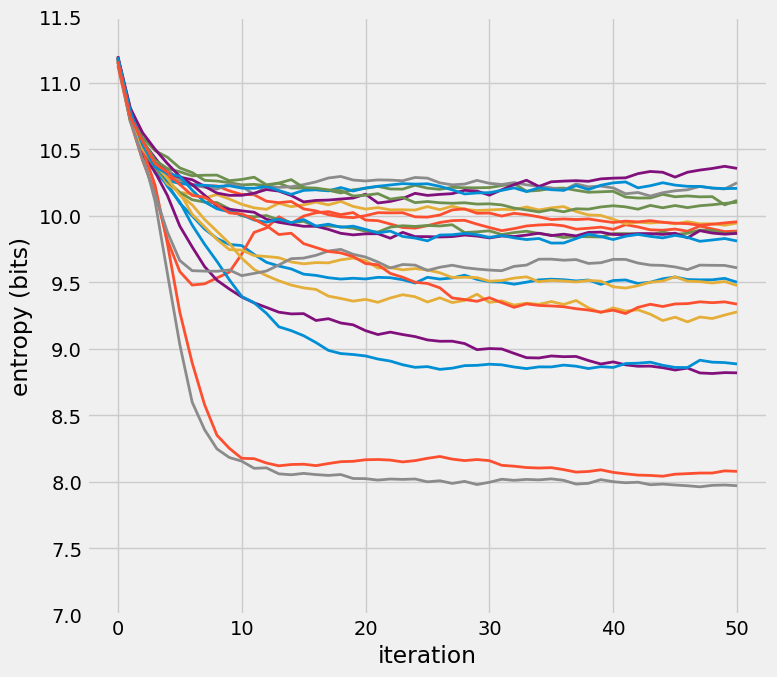

In [ ]:
#compare to zipf's law
plt.figure(figsize = (8, 7))
plt.plot(ents, linewidth=2.0)
plt.ylabel('entropy (bits)')
plt.xlabel('iteration')
plt.ylim(7.0, 11.5)


plt.tight_layout()
plt.show()